# Recommender Systems with Surprise
- **Created by Andrés Segura Tinoco**
- **Created on May 23, 2019**

## Experiment description
- Model built from a plain text file
- The algorithm used is: KNNBasic
- Model trained using the technique of cross validation (5 folds)
- The RMSE and MAE metrics were used to estimate the model error
- Type of filtering: User-based collaborative

In [1]:
# Load the Pandas libraries
import os
import io
import numpy as np
from collections import defaultdict

In [2]:
# Load Surprise libraries
from surprise import KNNBasic
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate

In [3]:
# Load Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Loading data

In [4]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.data')

In [5]:
# Read the data into a Surprise dataset
reader = Reader(line_format = 'user item rating timestamp', sep = '\t', rating_scale = (1, 5))
data = Dataset.load_from_file(file_path, reader = reader)

## 2. Train the model and measure its error

A basic collaborative filtering algorithm. The prediction $\hat{r}_{ui}$ is set as:

$$ \hat{r}_{ui} = \frac{ \sum_{v \in N_{i}^{k}(u)} {sim(u,v) . r_{vi}} }{ \sum_{v \in N_{i}^{k}(u)} {sim(u,v) } } \tag{1} $$

In [6]:
# Use k-NN algorithm with user-based collaborative filtering and cosine similarity
kk = 50
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNBasic(k = kk, sim_options = sim_options, verbose = True)

In [7]:
# Run 5-fold cross-validation and print results
cv = cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0184  1.0203  1.0148  1.0125  1.0131  1.0158  0.0031  
MAE (testset)     0.8035  0.8080  0.8050  0.8008  0.8021  0.8039  0.0025  
Fit time          2.10    2.00    1.94    2.53    2.03    2.12    0.21    
Test time         4.20    4.28    4.76    4.69    4.72    4.53    0.24    


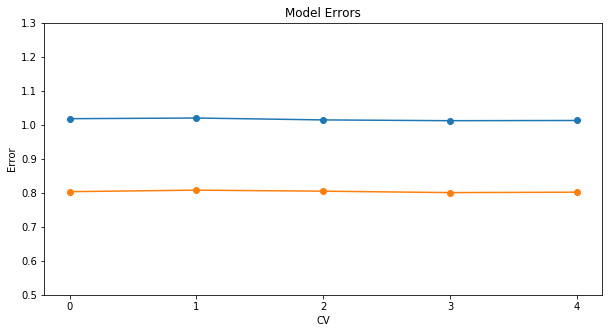

In [8]:
# Get data
rmse = cv['test_rmse']
mae = cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(x, rmse, marker = 'o')
ax.plot(x, mae, marker = 'o')

# Chart setup
plt.title("Model Errors", fontsize = 12)
plt.xlabel("CV", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.draw()

## 3. Make some predictions

In [9]:
# Without real rating
p1 = algo.predict(uid = '13', iid = '181', verbose = True)

user: 13         item: 181        r_ui = None   est = 4.12   {'actual_k': 50, 'was_impossible': False}


In [10]:
# With real rating
p2 = algo.predict(uid = '196', iid = '302', r_ui = 4, verbose = True)

user: 196        item: 302        r_ui = 4.00   est = 4.22   {'actual_k': 50, 'was_impossible': False}


## 4. Get the k nearest neighbors of an item

In [11]:
# Return two mappings to convert raw ids into movie names and movie names into raw ids
def read_item_names(file_path):
    rid_to_name = {}
    name_to_rid = {}
    
    with io.open(file_path, 'r', encoding = 'ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]
    
    return rid_to_name, name_to_rid

In [12]:
# Read the mappings raw id <-> movie name
item_filepath = '../data/u.item'
rid_to_name, name_to_rid = read_item_names(item_filepath)

In [13]:
# Target movie
target_movie = 'Toy Story (1995)'

In [14]:
# Retrieve inner id of the movie Toy Story
toy_story_raw_id = name_to_rid[target_movie]
toy_story_inner_id = algo.trainset.to_inner_iid(toy_story_raw_id)
print(target_movie + ':', toy_story_inner_id)

Toy Story (1995): 133


In [15]:
# Retrieve inner ids of the nearest neighbors of Toy Story
toy_story_neighbors = algo.get_neighbors(toy_story_inner_id, k = 10)
toy_story_neighbors

[287, 874, 923, 941, 832, 896, 764, 682, 825, 625]

In [16]:
# The 10 nearest neighbors of Toy Story are:
print("The movies most similar to '" + target_movie + " are:")

for inner_id in toy_story_neighbors:
    raw_id = algo.trainset.to_raw_iid(inner_id)
    movie = rid_to_name[raw_id]
    print(raw_id, '-', movie)

The movies most similar to 'Toy Story (1995) are:
283 - Emma (1996)
280 - Up Close and Personal (1996)
1221 - When a Man Loves a Woman (1994)
1109 - Death and the Maiden (1994)
560 - Kid in King Arthur's Court, A (1995)
530 - Man Who Would Be King, The (1975)
1147 - My Family (1995)
510 - Magnificent Seven, The (1954)
541 - Mortal Kombat (1995)
919 - City of Lost Children, The (1995)


## 5. Get the top-N recommendations

In [17]:
# Return the top-N recommendation for each user from a set of predictions.
def get_top_n(predictions, n = 10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [18]:
# Create train_set and test_set
train_set = data.build_full_trainset()
test_set = train_set.build_anti_testset()

# First train a KNN algorithm on the whole dataset
algo.fit(train_set)
predictions = algo.test(test_set)

# RMSE should be low as we are biased
accuracy.rmse(predictions, verbose = True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9255


0.9254759689787458

In [19]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set
top_n = 10
top_pred = get_top_n(predictions, n = top_n)

In [20]:
# User raw Id
uid_list = ['196']

# Print the recommended items for a specific user
for uid, user_ratings in top_pred.items():
    if uid in uid_list:
        for (iid, rating) in user_ratings:
            movie = rid_to_name[iid]
            print('Movie:', iid, '-', movie, ', rating:', str(rating))

Movie: 1189 - Prefontaine (1997) , rating: 5
Movie: 1500 - Santa with Muscles (1996) , rating: 5
Movie: 814 - Great Day in Harlem, A (1994) , rating: 5
Movie: 1536 - Aiqing wansui (1994) , rating: 5
Movie: 1293 - Star Kid (1997) , rating: 5
Movie: 1599 - Someone Else's America (1995) , rating: 5
Movie: 1653 - Entertaining Angels: The Dorothy Day Story (1996) , rating: 5
Movie: 1467 - Saint of Fort Washington, The (1993) , rating: 5
Movie: 1122 - They Made Me a Criminal (1939) , rating: 5
Movie: 1201 - Marlene Dietrich: Shadow and Light (1996)  , rating: 5


---
<a href="https://ansegura7.github.io/RS_Surprise/">&laquo; Home</a>